In [83]:
from scipy.special import erf
from scipy.optimize import curve_fit
import numpy as np
from numpy import array

from sklearn.ensemble import RandomForestRegressor

import pandas as pd
from util import util

from datetime import datetime

<h1>Global Dataframes and Variables</h1>

In [84]:
# We import the sample_submission.csv file as a way of determining
# the order of the rows in out output file
sample_submission = pd.read_csv("../sample_submission.csv")

# The fips_key.csv file contains standard information about each county
key = pd.read_csv("../data/us/processing_data/fips_key.csv", encoding='latin-1')

# Daily deaths contains the death count per day for each county.
# Cumulative deaths contains the total death count for each county
# by day.
daily_deaths = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv")
cumulative_deaths = pd.read_csv("../data/us/covid/deaths.csv")
county_land_areas = pd.read_csv("../data/us/demographics/county_land_areas.csv", encoding='latin1')
county_population = pd.read_csv("../data/us/demographics/county_populations.csv", encoding='latin1')
mobility_data = pd.read_csv("../data/us/mobility/DL-us-m50.csv", encoding='latin1')

# List of all counties
all_fips = key["FIPS"].tolist()

util = util(daily_deaths, cumulative_deaths, county_land_areas, county_population, mobility_data, key)

MIN_TOTAL_DEATHS = 50
MIN_DAYS_SINCE_FIRST_DEATH = 20

# Relevant dates
today = cumulative_deaths.columns[-1]
yesterday = cumulative_deaths.columns[-2]
one_week_ago = cumulative_deaths.columns[-8]
two_weeks_ago = cumulative_deaths.columns[-15]
beginning = cumulative_deaths.columns[4]

<h1>Helpful Date Functions</h1>

In [85]:
# Get all dates used over the course of the term
all_dates = sample_submission["id"].values.copy()

def extract_date_from_id(row_id):
    split = row_id.split('-')
    return '-'.join(split[:-1])

for i in range(len(all_dates)):
    all_dates[i] = extract_date_from_id(all_dates[i])

# Remove duplicates in the list
all_dates = list(dict.fromkeys(all_dates))

# Assume date is in format mm/dd/yy, convert to yyyy-mm-dd
def convert_date_to_yyyy_mm_dd(date):
    parts = date.split('/')
    
    # Ensure leading zeros if necessary
    if len(parts[0]) == 1:
        parts[0] = "0" + parts[0]
    
    if len(parts[1]) == 1:
        parts[1] = "0" + parts[1]
        
    return "2020" + "-" + parts[0] + "-" + parts[1]

# Assume date is in format yyyy-mm-dd, convert to mm/dd/yy
def convert_date_to_mm_dd_yy(date):
    parts = date.split('-')
    
    # Remove leading zeros if necessary
    if parts[1][0] == "0":
        parts[1] = parts[1][1:]
    
    if parts[2][0] == "0":
        parts[2] = parts[2][1:]
        
    return parts[1] + "/" + parts[2] + "/" + "20"

# Starting from a given date, take an input number of steps
# and compute a list of dates containg the start date and
# "steps" dates into the future, for a total of steps
# dates.
def get_dates_from_start(startDate, steps):
    dates = all_dates[all_dates.index(startDate):all_dates.index(startDate) + steps]
    return dates

# Get the next date of a given date
def get_next_date(startDate):
    return get_dates_from_start(startDate, 2)[1]

<h1>Functions Used for Curve Fitting</h1>

In [86]:
def erf_curve(times, log_max, slope, center):
    max_val = 10 ** log_max
    deaths = max_val * (1 + erf(slope * (times - center)))
    return deaths

def eval_erf(times, coefs):
    max_val = 10 ** coefs[0]
    deaths = max_val * (1 + erf(coefs[1] * (times - coefs[2])))
    return deaths

def linear_curve(times, slope, intercept):
    return [x * slope for x in times] + intercept

def constant_curve(times, c):
    return [x * c for x in times]

In [102]:
def get_cumulative_from_daily(daily):
    cumulative = []
    curr = 0
    for deaths in daily:
        curr += deaths
        cumulative.append(curr)
    
    return cumulative

def get_deaths_on_date(fips, date):
    if not '-' in date:
        sys.exit("Error: date in wrong format. Use yyyy-mm-dd.")

    rows = daily_deaths.loc[daily_deaths["fips"] == fips]
    deaths_list = rows["deaths"].values
    dates_list = rows["date"].values

    if date in dates_list:
        index = list(dates_list).index(date)
    else:
        return []

    return deaths_list[index]

def get_erf_curve(fips, endDate):
    daily_deaths_list = util.get_deaths_list(fips, endDate=endDate)
    cumulative_deaths_list = get_cumulative_from_daily(daily_deaths_list)

    # Compute x and y lists to pass to curve_fit
    x = [i for i in range(len(cumulative_deaths_list))]
    y = cumulative_deaths_list
    
    if len(cumulative_deaths_list) < MIN_DAYS_SINCE_FIRST_DEATH or y[-1] < MIN_TOTAL_DEATHS:
        return [0, 0, 0]
    
    popt, pcov = curve_fit(erf_curve, x, y, maxfev=10000)
    
    return popt

def get_erf_scaled_residuals(fips, end_train_date, n_steps):
    erf_coefs = get_erf_curve(fips, end_train_date)
    
    train_daily_deaths = util.get_deaths_list(fips, endDate=end_train_date)
    all_daily_deaths = util.get_deaths_list(fips, endDate=convert_date_to_yyyy_mm_dd(today))
    
    assert len(train_daily_deaths) + n_steps < len(all_daily_deaths)
    
    x_input = []
    for i in range(len(train_daily_deaths), len(train_daily_deaths) + n_steps):
        x_input.append(i)
    
    cumulative_train_deaths = get_cumulative_from_daily(train_daily_deaths)
    
    predictions = [cumulative_train_deaths[-1]]
    for i in x_input:
        predictions.append(eval_erf(i, erf_coefs))
    
    predictions = np.diff(predictions)

    residuals = []
    for i, pred in enumerate(predictions):
        residuals.append((pred - all_daily_deaths[x_input[i]]) / pred)
        
    assert len(residuals) == n_steps
    
    return residuals, erf_coefs

def get_erf_residuals(fips, end_train_date, n_steps):
    train_daily_deaths = util.get_deaths_list(fips, endDate=end_train_date)
    all_daily_deaths = util.get_deaths_list(fips, endDate=convert_date_to_yyyy_mm_dd(today))
    
    # Get an optimal erf curve fit for this county up to end_train_date
    erf_coefs = get_erf_curve(fips, end_train_date)
    
    # Ensure that there are n_steps more dates after the end of the train date
    assert len(train_daily_deaths) + n_steps <= len(all_daily_deaths)
    
    # Generate an input array to evaluate predictions on the coming n_steps dates
    x_input = []
    for i in range(len(train_daily_deaths), len(train_daily_deaths) + n_steps):
        x_input.append(i)
    
    cumulative_train_deaths = get_cumulative_from_daily(train_daily_deaths)
    all_cumulative_deaths = get_cumulative_from_daily(all_daily_deaths)
    
    # Make predictions for the next n_steps days
    predictions = []
    for i in x_input:
        predictions.append(eval_erf(i, erf_coefs))
    
    # Compute the residuals of the predictions
    residuals = []
    for i, pred in enumerate(predictions):
        residuals.append(all_cumulative_deaths[x_input[i]] - pred)
        
    assert len(residuals) == n_steps
    
    return residuals

def build_input_vector(fips, n_steps, curr_index, date, last_train_date):
    input_vector = [curr_index]

    input_vector.append(util.get_population_per_square_mile(fips))
    input_vector.append(util.get_square_miles(fips))
    input_vector.append(util.get_total_population(fips))
    input_vector.append(util.get_percentage_over_60(fips))
    input_vector = input_vector + list(util.get_mobility_data_list(fips, last_train_date, 30))
    input_vector.append(datetime.strptime(date, "%Y-%m-%d").weekday())
    
    return input_vector

In [104]:
n_steps = 14
window_size = 14
last_train_date = "2020-04-05"
dates_to_consider = get_dates_from_start(get_next_date(last_train_date), n_steps)

residuals_map = {}

x_train = []
y_train = []

for fips in all_fips:
    daily_deaths_list = util.get_deaths_list(fips, endDate=last_train_date)
    
    if len(daily_deaths_list) < 30 or daily_deaths_list[-1] < 2:
        continue
        
    print(fips)
    
    residuals = get_erf_residuals(fips, last_train_date, n_steps)
    residuals_map[fips] = residuals

    for i in range(0, len(residuals)):
        x_in = build_input_vector(fips, n_steps, i, dates_to_consider[i], last_train_date)

        x_train.append(list(x_in))
        
        y_train.append(residuals[i])
        
regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=1000, n_jobs=-1)
regr.fit(x_train, y_train)

4013
6037
6067
8031
8041
8059
12011
13121
17031
18097
24031
25003
25017
29189
34003
36061
42091
48201
53033
53053
53061


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [105]:
fips = 6037
new_dates_to_consider = get_dates_from_start(get_next_date(dates_to_consider[-1]), n_steps)

current_residuals = residuals_map[fips][n_steps - window_size : n_steps]

residuals_preds = []
for i in range(1, n_steps + 1):
    x_in = current_residuals[i - 1 : i + window_size]
    x_in += build_input_vector(fips, n_steps, i, new_dates_to_consider[i - 1], last_train_date)

    pred = regr.predict([x_in])[0] * stddev + mean
    residuals_preds.append(pred)
    current_residuals.append(pred)
    
print(residuals_preds)

# Obtain the actual residuals
actual_residuals = get_erf_residuals(fips, "2020-04-20", n_steps)

util.plot_list(actual_residuals)
util.plot_list(residuals_preds)
util.plot_list(array(actual_residuals) - array(residuals_preds))

ValueError: Number of features of the model must match the input. Model n_features is 36 and input n_features is 50 

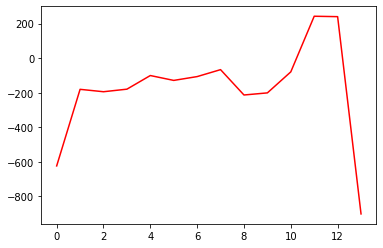

In [12]:
n_steps = 14
last_train_date = "2020-04-05"
dates_to_consider = get_dates_from_start(get_next_date(last_train_date), n_steps)

x_train = []
y_train = []

fips = 36061

daily_deaths_list = util.get_deaths_list(fips, endDate=last_train_date)

residuals = get_erf_residuals(fips, last_train_date, n_steps)

util.plot_list(residuals)